# Monte Carlo Pricing of Lookback Call Option with Stochastic Volatility

<b> YouTube Tutorial </b> (Published: Apr 24, 2022): https://youtu.be/HjaWw7f2ulk

In this tutorial we will investigate the Monte Carlo simulation method for use in valuing financial derivatives. The mathematic notation and examples are from Les Clewlow and Chris Strickland's book Implementing Derivatives Models.

Valuation of Financial Derivatives through Monte Carlo Simulations is only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

$\begin{equation}\LARGE
\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

Note: This is the Risk-neutral Expectation Pricing Formula in Continuous Time

In [ ]:
# Import dependencies
import time
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

## Path-Dependent Options - Lookback Options

In this example we are pricing a discretely monitored lookback call option with stochastic volatility. The option payoffs are dependent on the extreme values, maximum or minimum, of the underlying asset prices over a certain time period (lookback period). There are two standard lookback options: fixed strike and floating strike. Fixed strike lookback option options pay the difference (if positive) between the max ($M_0^T$) or min ($m_0^T$) of a set of observations, over a lookback period $[0,T]$ of the asset price $S_{t_i}$ and the strike price $K$ at the maturity date $T$.

For an Fixed Strike Lookback Call Options: $C_T = max(0, M_0^T - K)$

For an Fixed Strike Lookback Put Options: $C_T = max(0, K - m_0^T)$

Where:
- $M_0^T = max(S_{t_i} : i = 1,...,N)$
- $m_0^T = min(S_{t_i} : i = 1,...,N)$

## Heston Model for Stochastic Volatility

<i>Underlying SDE's under risk-neutral measure:
<center>
$dS_{t} = (r-\delta) S_{t} dt + \sqrt{v_{t}} S_{t} dW^\mathbb{Q}_{1,t}$</center>

<i>Variance Process:
<center>
$dv_{t} = \kappa (\theta - v_{t})dt + \sigma \sqrt{v_{t}} dW^\mathbb{Q}_{2,t}$</center>

    
$\rho^\mathbb{Q} dt=dW^\mathbb{Q}_{1,t} dW^\mathbb{Q}_{2,t}$
    
Let's assume no correlation or $\rho = 0$

In [ ]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 100        # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)
div = 0.03     # continuous dividend yield

# Heston parameters
kappa = 5.0
vt0 = vol**2    # variance
theta = 0.2**2
sigma = 0.02

## Slow Solution - Steps

In [ ]:
# slow steps
N = 52      # number of time intervals
M = 1000    # number of simulations

In [ ]:
start_time = time.time()

# Assume evenly spaced discrete lookback
dt = T/N

# Precompute constants
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):

    St = S0
    vt = vt0
    St_max = S0

    for j in range(N):

        # Generate Wiener variables
        W = np.random.normal(0.0, 1.0, size=(2))

        # variance process
        vt = vt + kappadt*(theta-vt) + sigmasdt*np.sqrt(vt)*W[0]

        # asset process
        St = St*np.exp( (r-div-0.5*vt)*dt + np.sqrt(vt*dt)*W[1])

        if St > St_max:
            St_max = St

    CT = max(0, St_max - K)
    # print(CT)
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0_slow = np.exp(-r*T)*sum_CT/M
SE_slow = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) ) / np.sqrt(M)

time_comp_slow = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_slow,3),np.round(SE_slow,3)))
print("Computation time is: ", time_comp_slow)

Call value is $16.193 with SE +/- 0.466
Computation time is:  0.6377


# Fast Implementation - Vectorized with Numpy

In [ ]:
# fast steps
N = 52      # number of time intervals
M = 1000    # number of simulations

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Generate Wiener variables
W = np.random.normal(0.0, 1.0, size=(N,M,2))

# arrays for storing prices and variances
St = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

    mask = np.where(St[j] > St_max)
    St_max[mask] = St[j][mask]

# Compute Expectation and SE
CT = np.maximum(0, St_max - K)
C0_fast = np.exp(-r*T)*np.sum(CT)/M

SE_fast = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) ) /np.sqrt(M)

time_comp_fast = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,2),np.round(SE_fast,2)))
print("Computation time is: ", time_comp_fast)

Call value is $16.06 with SE +/- 0.45
Computation time is:  0.0116


## Variation Reduction Comparison

### Antithetic

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Generate Wiener variables
W = np.random.normal(0.0, 1.0, size=(N,M,2))

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    St2[j] = St2[j-1]*np.exp( nudt - np.sqrt(vt[j]*dt)*W[j-1,:,1] )

    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]

# Compute Expectation and SE
CT = 0.5 * ( np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) )
C0_av = np.exp(-r*T)*np.sum(CT)/M

SE_av = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) ) /np.sqrt(M)

time_comp_av = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av,2),np.round(SE_av,2)))
print("Calculation time: {0} sec".format(time_comp_av))

Call value is $16.27 with SE +/- 0.21
Calculation time: 0.0133 sec


## Analytical Solution for Continuous Observations

There is no analytical solution for the price of European fixed strike lookback call options with discrete fixings and stochastic volatility under Heston model. However there is a simple analytical formula for the price of a continuously monitored (fixing) fixed strike lookback call with constant volatility.

$C_{FIXED \ STRIKE \ LOOKBACK \ CALL} = G + Se^{-\delta T}N(x+\sigma\sqrt{T})- Ke^{-rT}N(x) - \frac{S}{B}(e^{-rT}(\frac{E}{S})^B N(x+(1-B)\sigma \sqrt{T}) - e^{-\delta T}N(x+\sigma\sqrt{T}))$

Where:

$B = \frac{2(r-\delta)}{\sigma^2}$

$x = \frac{ln(\frac{S}{E}) + ((r-\delta)-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}$

$\left\{
  \begin{array}{ c l }
    E=K, G=0 & \quad \textrm{if } K \geq M \\
    E=M, G=e^{-rt}(M-K)                 & \quad \textrm{otherwise}
  \end{array}
\right.$

In [ ]:
class fixed_strike_lookback_call:
    def __init__(self, r, S, K, T, M, vol, div=0):
        self.r = r
        self.S = S
        self.K = K
        self.T = T
        self.M = M
        self.vol = vol
        self.div = div

    def option_price_vectorized(self):
        "Calculate fixed strike lookback call price of call/put"
        E = np.where(self.K < self.M, self.M, self.K)
        G = np.where(self.K < self.M, np.exp(-self.r*self.T)*(self.M-self.K), 0)

        x = (np.log(self.S/E) + ((self.r-self.div) - self.vol**2/2)*self.T)/(self.vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(self.vol**2)

        price = G + self.S*np.exp(-self.div*T)*norm.cdf(x+self.vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - self.S/B*(np.exp(-self.r*self.T)*(E/self.S)**B * norm.cdf(x+(1-B)*self.vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+self.vol*np.sqrt(self.T), 0, 1))

        return price

    def option_price_fd(self, S, vol):
        "Calculate fixed strike lookback call price of call/put"
        if self.K < self.M:
            E = self.M
            G = np.exp(-self.r*self.T)*(self.M-self.K)
        else:
            E = self.K
            G = 0
        x = (np.log(S/E) + ((self.r-self.div) - vol**2/2)*self.T)/(vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(vol**2)

        price = G + S*np.exp(-self.div*T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - S/B*(np.exp(-self.r*self.T)*(E/S)**B * norm.cdf(x+(1-B)*vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1))

        return price

    def option_price_fd_vectorized(self, S, vol):
        "Calculate fixed strike lookback call price of call/put"
        E = np.where(self.K < self.M, self.M, self.K)
        G = np.where(self.K < self.M, np.exp(-self.r*self.T)*(self.M-self.K), 0)

        x = (np.log(S/E) + ((self.r-self.div) - vol**2/2)*self.T)/(vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(vol**2)

        price = G + S*np.exp(-self.div*T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - S/B*(np.exp(-self.r*self.T)*(E/S)**B * norm.cdf(x+(1-B)*vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1))

        return price

    def FD_S(self, S):
        vol = self.vol
        return self.option_price_fd_vectorized(S, vol)

    def FD_vol(self, vol):
        S = self.S
        return self.option_price_fd_vectorized(S, vol)

    def delta_fd(self, delta=0.001):
        deltaS = delta*self.S
        return (self.FD_S(self.S+deltaS)-self.FD_S(self.S-deltaS)) / (2*deltaS)

    def gamma_fd(self, delta=0.001):
        deltaS = delta*self.S
        return (self.FD_S(self.S+deltaS)-2*self.FD_S(self.S)+self.FD_S(self.S-deltaS)) / (deltaS**2)

    def vega_fd(self, delta=0.001):
        deltaV = delta*self.vol
        return (self.FD_vol(self.vol+deltaV)-self.FD_vol(self.vol-deltaV))/(2*deltaV)

In [ ]:
cont_call = fixed_strike_lookback_call(r, S0, K, T, S0, vol, div)

print("Option Price: ", round(cont_call.option_price_vectorized(),3))
print("Delta: ", round(cont_call.delta_fd(),3))
print("Gamma: ", round(cont_call.gamma_fd(),3))
print("Vega: ", round(cont_call.vega_fd(),3))

ContPrice = cont_call.option_price_vectorized()

Option Price:  17.729
Delta:  1.119
Gamma:  0.035
Vega:  85.938


## General Control Variate Equation

For J control variates we have:

$ \Large C_0\exp(rT) = C_T - \sum^J_{i=j}\beta_j cv_j + \eta$

where
- $\beta_j$ are factors to account for the "true" linear relationship between the option pay-off and the control variate $cv_j$
- $\eta$ accounts for errors:
    - discrete rebalancing
    - approximations in hedge sensitivities (calc. delta / gamma)
    
    
Option price as the sum of the linear relationships with J control variates
    
$ \large C_T =\beta_0 + \sum^J_{i=j}\beta_j cv_j + \eta$

where $\beta_0 = C_0\exp(rT)$ is the forward price of the option

If we perform M simulations at discrete time intervals N we can regard the pay-offs and control variates as samples of the linear relationship with some noise. We can estimate the true relationship between control variates and option pay-offs with least-squares regression:

$\beta = (X'X)^{-1}X'Y$

We don't want biased estimates of $\beta_j$ so these should be precomputed by least-squares regression to establish the relationship between types of control variates and options first. These estaimates of $\beta_j$ values can then be used for $cv_j$ for pricing any option.  

## Implementation of Delta-based Control Variates

$\large cv_1 = \sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\delta S}(S_{t_{i+1}} - {\mathbb E}[S_{t_i}])\exp{r(T-t_{i+1})}$

$\large C_{t_0}\exp{rT} = C_T + \beta_1 cv_1 + \eta$


where with GBM dynamics:
- ${\mathbb E}[S_{t_{i+1}}] = S_{t_{i}} \exp (r \Delta t_i)$
- $\beta_1 = -1$ which is the appropriate value where we have exact delta for European Option

In [ ]:
# fast steps
N = 52      # number of time intervals
M = 1000    # number of simulations

In [ ]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

S = S0
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)

Y = np.maximum(0, ST[-1] - K)

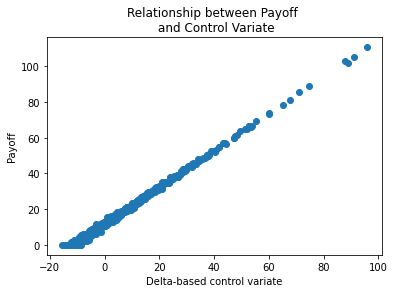

In [ ]:
plt.scatter(cv[-1],Y)
plt.title('Relationship between Payoff \n and Control Variate')
plt.ylabel('Payoff')
plt.xlabel('Delta-based control variate')
plt.show()

## Least-Squares Regression

Find "True" relationship between control variate hedges and payoff.

In [ ]:
X = np.vstack([np.ones(M), cv[-1]]).T
beta = np.linalg.lstsq(X, Y, rcond=1)[0]

print('Beta 0 (fair value T=0): ', round(beta[0],3))
print('Beta 1 (delta)         : ', round(beta[1],3))

Beta 0 (fair value T=0):  11.741
Beta 1 (delta)         :  1.028


## Gamma Based Control Variate

The control variate is a random variable whose expected value we know, which is correlated with the varaible we are trying to estimate.

In the same way as for $cv_1$ we can create other control variates, which are equivalent to other hedges.

For example a gamma-based control variate ($cv_2$):

$\large cv_2 = \sum^{N-1}_{i=0} \frac{\delta^2 C_{t_i}}{\delta S^2}((\Delta S_{t_{i+1}})^2 - {\mathbb E}[(\Delta S_{t_i})^2])\exp{r(T-t_{i+1})}$

Where ${\mathbb E}[(\Delta S_{t_i})^2] = S_{t_i}^2 (\exp([2r+\sigma^2]\Delta t_i)-2\exp(r\Delta t_i)+1)$

In [ ]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 100        # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)
div = 0.03     # continuous dividend yield
M = 100

# Heston parameters
kappa = 5.0
vt0 = vol**2    # variance
theta = 0.2**2
sigma = 0.02

In [ ]:
# fast steps
N = 52    # number of time intervals
M = 10000  # number of simulations

# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms

nudt = (r - div - 0.5*vt0)*dt
volsdt = np.sqrt(vt0*dt)
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# Generate Wiener variables
W = np.random.normal(0.0, 1.0, size=(N,M,2))

# initialise prices and variances
vt = np.full(shape=(M), fill_value=vt0)
St = np.full(shape=(M), fill_value=S0)

vtn = np.full(shape=(M), fill_value=0.0)
Stn = np.full(shape=(M), fill_value=0.0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

for j in range(1,N+1):
    # Compute hedge sensitivities
    call = fixed_strike_lookback_call(r, St, K, T-(j-1)*dt, St_max, np.sqrt(vt), div)
    delta = call.delta_fd()
    gamma = call.gamma_fd()
    vega = call.vega_fd()

    # Simulate variance processes
    vtn = vt + kappadt*(theta - vt) + sigmasdt*np.sqrt(vt)*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt)*dt
    Stn = St*np.exp( nudt + np.sqrt(vt*dt)*W[j-1,:,1] )

    # accumulate control variates
    cv1 += delta*(Stn - St*erddt)
    cv2 += gamma*((Stn - St)**2 - (egam1*np.exp(vt*dt) + egam2)*St**2)
    cv3 += vega*((vtn - vt) - (vt*eveg1+eveg2-vt))

    mask = np.where(Stn > St_max)
    St_max[mask] = Stn[mask]

    vt = vtn
    St = Stn

# Compute Expectation and SE
Y = np.maximum(0, St_max - K)

In [ ]:
C0 = np.exp(-r*T)*np.sum(Y)/M
C0

16.073849831976542

In [ ]:
X = np.vstack([np.ones(M), cv1, cv2, cv3]).T

beta = np.linalg.lstsq(X, Y, rcond=None)[0]
print('Beta 0        : ',round(beta[0],3))
print('Beta 1 (delta): ',round(beta[1],3))
print('Beta 2 (gamma): ',round(beta[2],3))
print('Beta 3 (vega) : ',round(beta[3],3))

Beta 0        :  16.985
Beta 1 (delta):  0.583
Beta 2 (gamma):  0.232
Beta 3 (vega) :  0.777


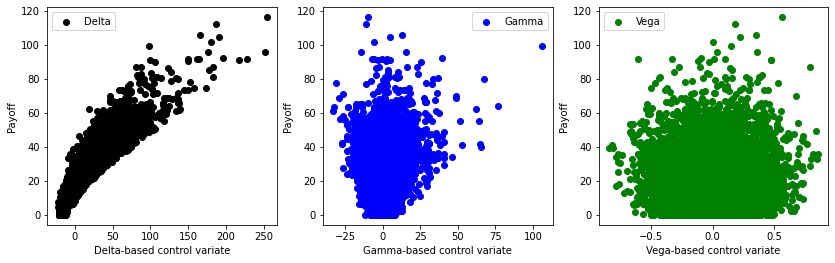

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
naming = ['Delta','Gamma','Vega']
ax[0].scatter(cv1,Y,label=naming[0],color='k')
ax[1].scatter(cv2,Y,label=naming[1],color='b')
ax[2].scatter(cv3,Y,label=naming[2],color='g')
for i,a in enumerate(ax):
    a.set_ylabel('Payoff')
    a.set_xlabel(naming[i]+'-based control variate')
    a.legend()
plt.show()

In [ ]:
# fast steps
N = 52      # number of time intervals
M = 1000    # number of simulations

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# linear constants pre-determined for control variate weighting
beta1 = -beta[1]#-0.88
beta2 = -beta[2]#-0.43
beta3 = -beta[3]#-0.0003

# Generate Wiener variables
W = np.random.normal(0.0, 1.0, size=(N,M,2))

# arrays for storing prices and variances
St = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

for j in range(1,N+1):

    # Compute hedge sensitivities
    call = fixed_strike_lookback_call(r, St[j-1], K, T-(j-1)*dt, St_max, np.sqrt(vt[j-1]), div)
    delta = call.delta_fd()
    gamma = call.gamma_fd()
    vega = call.vega_fd()

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

    # accumulate control variates
    cv1 += delta*(St[j] - St[j-1]*erddt)
    cv2 += gamma*((St[j] - St[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St[j-1]**2)
    cv3 += vega*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1]))

    mask = np.where(St[j] > St_max)
    St_max[mask] = St[j][mask]

# Compute Expectation and SE
CT = np.maximum(0, St_max - K) + beta1*cv1 + beta2*cv2 + beta3*cv3
C0_cv = np.exp(-r*T)*np.sum(CT)/M

SE_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_cv)**2) / (M-1) ) /np.sqrt(M)

time_comp_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_cv,2),np.round(SE_cv,2)))
print("Calculation time: {0} sec".format(time_comp_cv))

Call value is $15.85 with SE +/- 0.2
Calculation time: 0.3286 sec


### Antithetic and control Variate

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# linear constants pre-determined for control variate weighting
beta1 = -beta[1]#-0.88
beta2 = -beta[2]#-0.43
beta3 = -beta[3]#-0.0003

# Generate Wiener variables
W = np.random.normal(0.0, 1.0, size=(N,M,2))

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):
    # Compute hedge sensitivities
    call1 = fixed_strike_lookback_call(r, St1[j-1], K, T-(j-1)*dt, St1_max, np.sqrt(vt[j-1]), div)
    call2 = fixed_strike_lookback_call(r, St2[j-1], K, T-(j-1)*dt, St2_max, np.sqrt(vt[j-1]), div)
    delta1 = call1.delta_fd()
    delta2 = call2.delta_fd()
    gamma1 = call1.gamma_fd()
    gamma2 = call2.gamma_fd()
    vega1 = call1.vega_fd()
    vega2 = call2.vega_fd()

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    St2[j] = St2[j-1]*np.exp( nudt - np.sqrt(vt[j]*dt)*W[j-1,:,1] )

    # accumulate control variates
    cv1 += delta1*(St1[j] - St1[j-1]*erddt) + delta2*(St2[j] - St2[j-1]*erddt)
    cv2 += gamma1*((St1[j] - St1[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St1[j-1]**2) \
         + gamma2*((St2[j] - St2[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St2[j-1]**2)
    cv3 += vega1*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1])) \
         + vega2*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1]))

    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]

# Compute Expectation and SE
CT = 0.5*(np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) \
      + beta1*cv1 + beta2*cv2 + beta3*cv3)

C0_acv = np.exp(-r*T)*np.sum(CT)/M

SE_acv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_acv)**2) / (M-1) ) /np.sqrt(M)

time_comp_acv = round(time.time() - start_time,4)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_acv,2),np.round(SE_acv,2)))
print("Calculation time: {0} sec".format(time_comp_acv))

Call value is $15.98 with SE +/- 0.11
Calculation time: 0.6484 sec


## Comparing Variance Reduction Methods

In [ ]:
C0_variates = [C0_slow, C0_fast, C0_av, C0_cv, C0_acv]
se_variates = [SE_slow, SE_fast, SE_av, SE_cv, SE_acv]
se_red = [round(SE_fast/se,2) for se in se_variates]
comp_time = [time_comp_slow, time_comp_fast, time_comp_av, time_comp_cv, time_comp_acv]
rel_time = [round(mc_time/time_comp_fast,2) for mc_time in comp_time]
data = {'Lookback Call Option Value': np.round(C0_variates,3),
        'Standard Error SE': np.round(se_variates,3),
        'SE Reduction Multiple': se_red,
        'Relative Computation Time': rel_time}

# Creates pandas DataFrame.
df = pd.DataFrame(data, index =['Slow Estimate', 'Fast Estimate', 'with antithetic variate',
'with control variates', 'with antithetic and control variates'])
df

,Lookback Call Option Value,Standard Error SE,SE Reduction Multiple,Relative Computation Time
Slow Estimate,16.193,0.466,0.97,54.97
Fast Estimate,16.060,0.452,1.00,1.00
with antithetic variate,16.268,0.206,2.20,1.15
with control variates,15.853,0.197,2.30,28.33
with antithetic and control variates,15.982,0.114,3.96,55.90
